Prediksi Dengan Prophet

In [521]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [522]:
# Memanggil Dataset
Dataset = pd.read_csv('BBRI.JK.csv')
Dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-11,3545.393311,3545.393311,3481.758057,3509.030273,2840.034912,51418628
1,2019-03-12,3527.211914,3536.302490,3463.576416,3490.848877,2825.319824,69851316
2,2019-03-13,3454.485840,3463.576416,3436.304199,3445.395020,2788.531494,51432598
3,2019-03-14,3436.304199,3499.939453,3436.304199,3490.848877,2825.319824,99175072
4,2019-03-15,3545.393311,3590.847168,3536.302490,3590.847168,2906.253662,106867285


In [523]:
# Filter Data
Dataset= Dataset[['Date','High']]
Dataset.head()

,Date,High
0,2019-03-11,3545.393311
1,2019-03-12,3536.302490
2,2019-03-13,3463.576416
3,2019-03-14,3499.939453
4,2019-03-15,3590.847168


In [524]:
# Merubah tipe kolom date menjadi datetime
Dataset['Date'] = pd.to_datetime(Dataset['Date'])
Dataset.head()

,Date,High
0,2019-03-11,3545.393311
1,2019-03-12,3536.302490
2,2019-03-13,3463.576416
3,2019-03-14,3499.939453
4,2019-03-15,3590.847168


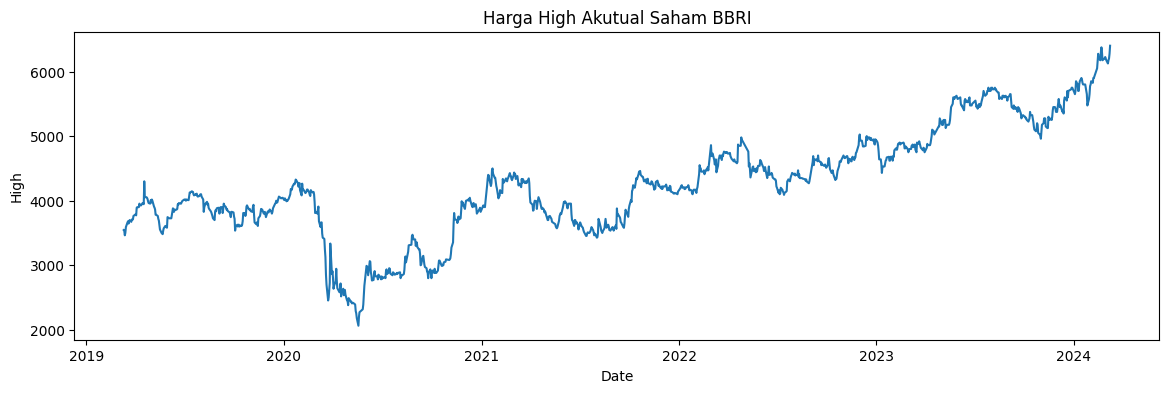

In [525]:
# Visualisasi Data pada dataset
plt.figure(figsize=(14, 4))
sns.lineplot(x=Dataset["Date"], y=Dataset["High"])
plt.title("Harga High Akutual Saham BBRI")
plt.show()

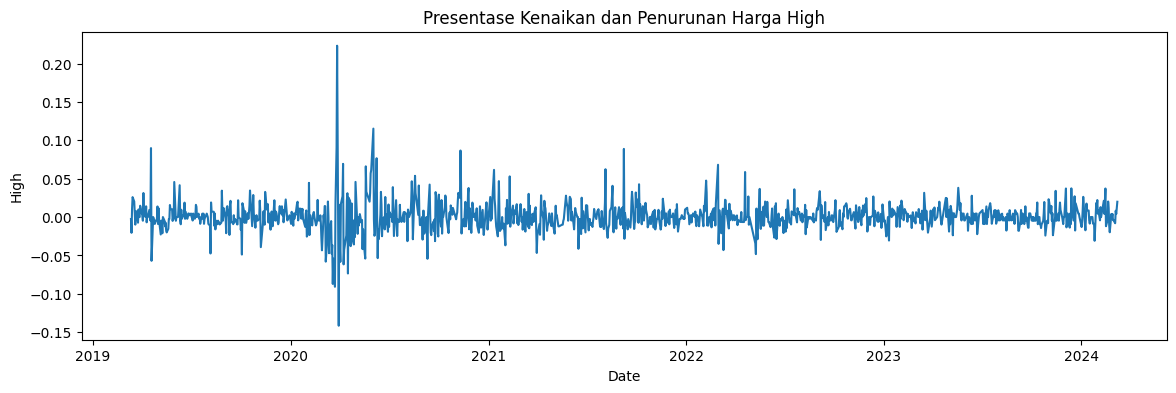

In [526]:
# Visualitasi presentasi kenaikan dan penurunan harga high pada dataset
plt.figure(figsize=(14, 4))
sns.lineplot(x=Dataset["Date"], y=Dataset["High"].pct_change())
plt.title("Presentase Kenaikan dan Penurunan Harga High")
plt.show()

In [527]:
N_SPLITS = 2

X = Dataset['Date']
y = Dataset['High']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

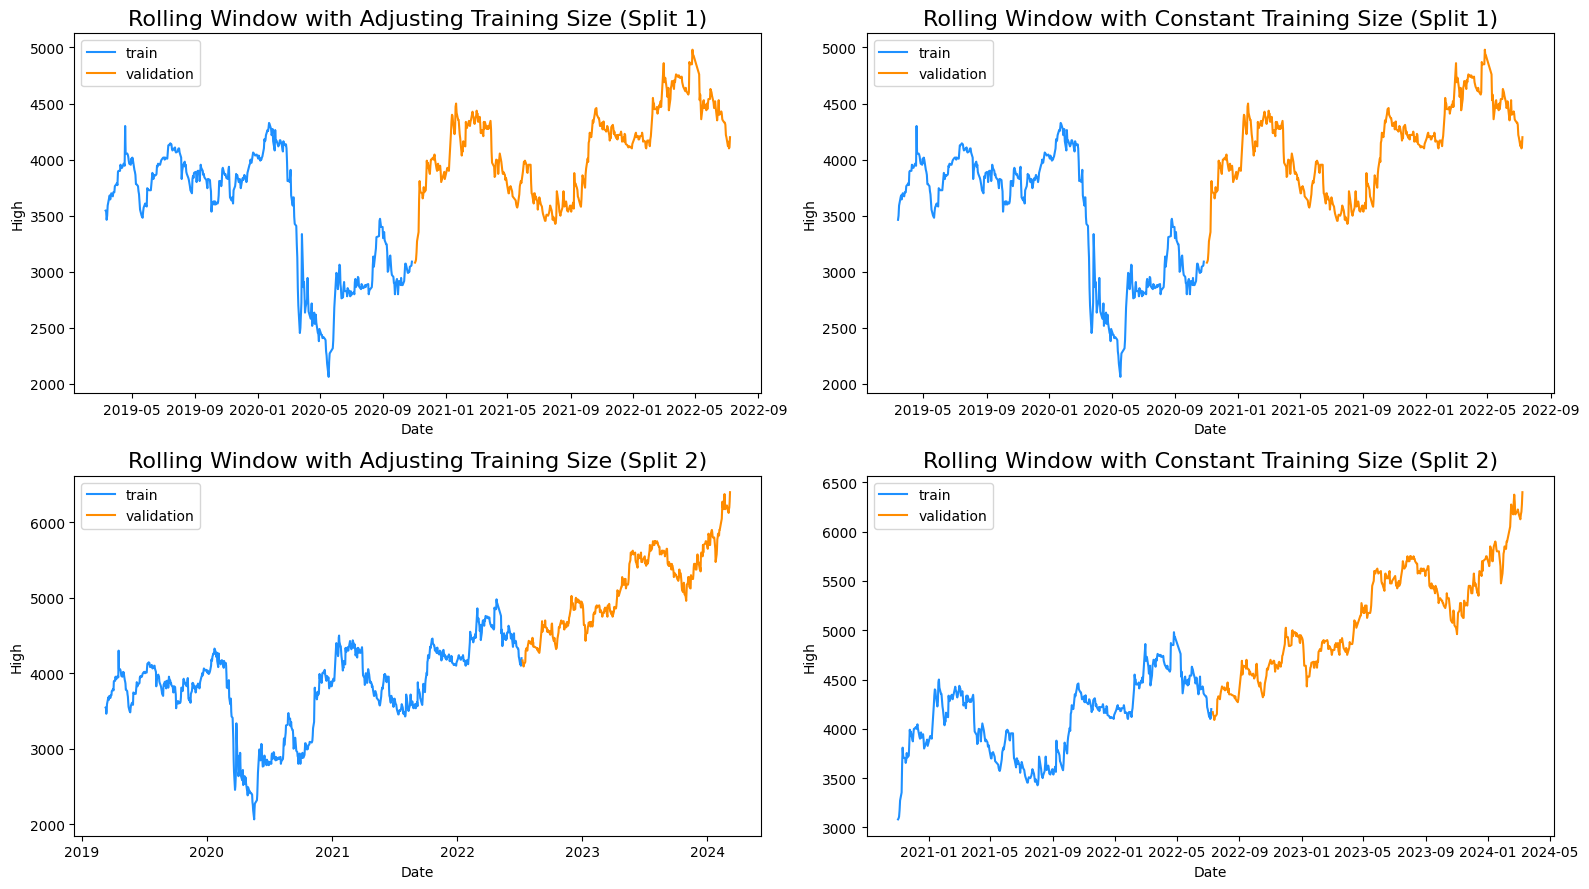

In [528]:
# Visualisasi pembagian data dengan rolling window
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)
    
plt.tight_layout()
plt.show()

In [529]:
train_size = int(0.85 * len(Dataset))
test_size = len(Dataset) - train_size

univariate_df = Dataset[['Date', 'High']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

1044 185


In [530]:
# Latih Model
model = Prophet()
model.fit(train)

19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing


In [531]:
import math
from colorama import Fore

# Predict on valid set
y_pred = model.predict(x_valid)

# Menghitung MAE, RMSE, dan MAPE
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score_mape = mean_absolute_percentage_error(y_valid, y_pred.tail(test_size)['yhat'])

print(Fore.GREEN + 'MAPE: {}%'.format(score_mape))
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))

MAPE: 8.21068587661278%
RMSE: 484.9618962082493
MAE: 412.7619114382347


/home/vermikanz/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vermikanz/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


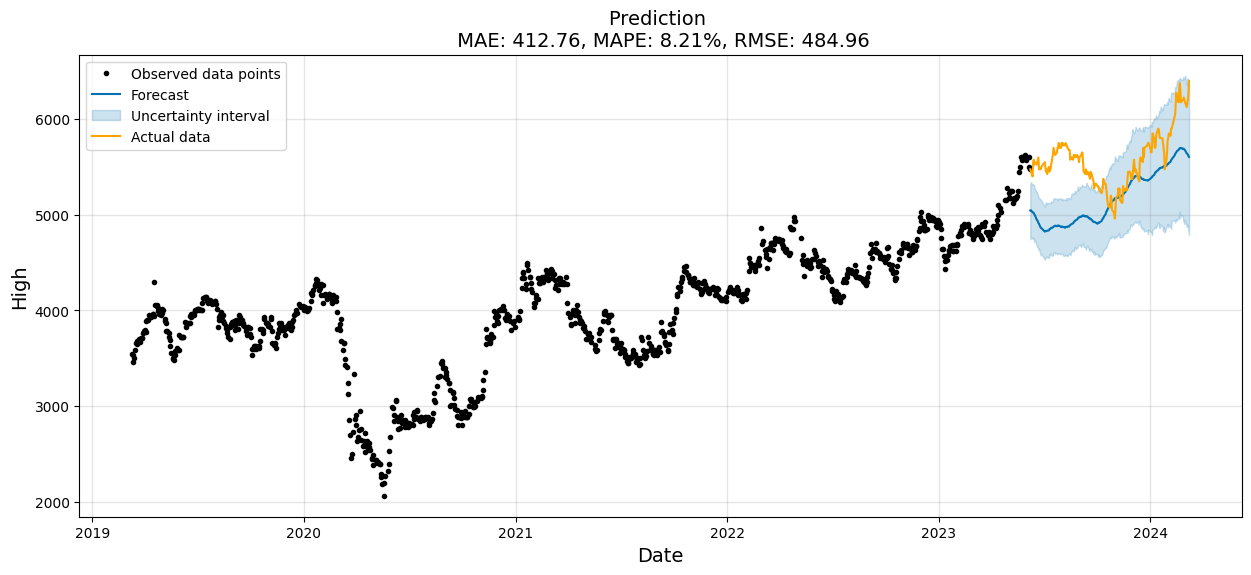

In [532]:
# Visualisasi hasil Prediksi
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Actual data')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, MAPE: {score_mape:.2f}%, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='High', fontsize=14)

plt.show()